<a href="https://colab.research.google.com/github/katduecker/dnn_osci/blob/main/DynNN_figures_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Settings - Paths - Clone github rep

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# clone github
!git clone https://github.com/katduecker/dnn_osci

# enter folder
%cd dnn_osci
%cd aet_pytorch/


load_NN = False       # load pre-trained NN?
save_NN = False       # save trained NN?

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: destination path 'dnn_osci' already exists and is not an empty directory.
/content/dnn_osci
/content/dnn_osci/aet_pytorch


In [ ]:
# import packages

import torch
from torch import nn
import numpy as np

# get CUDA index
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# colours for plot
col = mcolors.TABLEAU_COLORS

from itertools import combinations


plt.rcParams["figure.figsize"] = (18,3)

font = {'weight' : 'normal',
        'size'   : 14,
        'family' : 'sans-serif'}
plt.rc('font',**font)

In [ ]:
import aet_net            # 1-layer architecture
import aet_net_2lay       # 2-layer architecture


## Helper functions

In [ ]:
# sigmoid activation with option to stretch and shift
def sigmoid(z,sig_param):

    _slope,_bias = sig_param

    return 1.0/(1.0+np.exp(-_slope*(z+_bias)))

In [ ]:
# forward dynamics/discretization, euler integration
def euler_dyn(Z,t_,params_,alpha_params_,sig_param):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,c,S,h_start,R_start,t_start = params_


    # alpha frequency & amplitude
    _af,_aa,_ap = alpha_params_


    # initialize empty matrices
    dt = np.diff(t_)[0]
    dh1dt = (np.zeros((len(t_)+1,)))
    dR1dt = (np.zeros((len(t_)+1,)))
    dR1dt[0] = R_start;
    dZdt = (np.zeros((len(t_)+1,)))

    # alpha inhibition
    alpha_inh1 = _aa*np.sin(2*np.pi*_af*t_+_ap)+_aa

    boxcar = np.zeros(len(t_))
    boxcar[t_start:] = 1

    for _it,t in enumerate(t_):

        # pre-activation
        dZdt[_it+1] = (Z*boxcar[_it] + dh1dt[_it] - dR1dt[_it] - alpha_inh1[_it])/S

        # dynamics hidden layer1
        dh1dt[_it+1] = dh1dt[_it] + dt/tau_h * (-dh1dt[_it] + sigmoid(dZdt[_it+1],sig_param))

        # adaptation term 1
        dR1dt[_it+1] = dR1dt[_it] + dt/tau_R * (-dR1dt[_it] + c*dh1dt[_it+1])



    return dZdt, dh1dt, dR1dt

In [ ]:
# create stimuli

x_train, y_train = aet_net_2lay.aet_stim.mkstim()
x_train = x_train.to(DEVICE)
y_train = y_train.to(DEVICE)

# Train networks

In [ ]:
nn_dim_ = [28,64,32,3]   # [quadrant size, number of hidden nodes, number of output nodes]
eta_ = 1e-3           # learning rate
mini_sz_ = 1          # mini batch size (1 = use SGD)
num_epo_ = 100

beta_ = 0
p_ = .02              # has to be != 0 even if not used
kl_reg_ = [beta_,p_,1]#[0,0.001] # sparsity constraint parameters (not used for manual model)
sig_param =[[2, -2.5, False],[2, -2.5, False]] # sigmoid slope and shift in x direction

ortho_lmbda = 0
ortho_layer = 2

# loss function & final layer activation (for binary crossentropy use sigmoid)
lossfun = [nn.MSELoss(), nn.Softmax(dim=-1)]

params = nn_dim_,eta_,mini_sz_,num_epo_,kl_reg_,sig_param,ortho_lmbda,ortho_layer

# initialize model and weights
model2 = aet_net_2lay.net(params,lossfun)
model2 = aet_net_2lay.init_params(model2,weight_init='uni')

optimizer = torch.optim.Adam(model2.parameters(),lr=eta_)

model2.to(DEVICE)
loss_hist2 = model2.train(optimizer,noise=False,print_loss=False)

In [ ]:
# hidden layer activations

Z21,H21,H22,O2 = model2.forw_conv(x_train)

Z22 = model2.fc1(H21)

In [ ]:
idx = np.array((0,4,8))
label = ['A','E','T']

In [ ]:
font = {'weight' : 'normal',
        'size'   : 10,
        'family' : 'sans-serif'}
plt.rc('font',**font)


plt.rcParams["figure.figsize"] = (8.9,8)


fig = plt.figure(layout="constrained")
gs0 = fig.add_gridspec(1, 2)

gs00 = gs0[0].subgridspec(1, 1)
gs01 = gs0[1].subgridspec(2, 2)

<Figure size 890x800 with 0 Axes>

In [ ]:
np.arange(1,65,7)

array([ 1,  8, 15, 22, 29, 36, 43, 50, 57, 64])

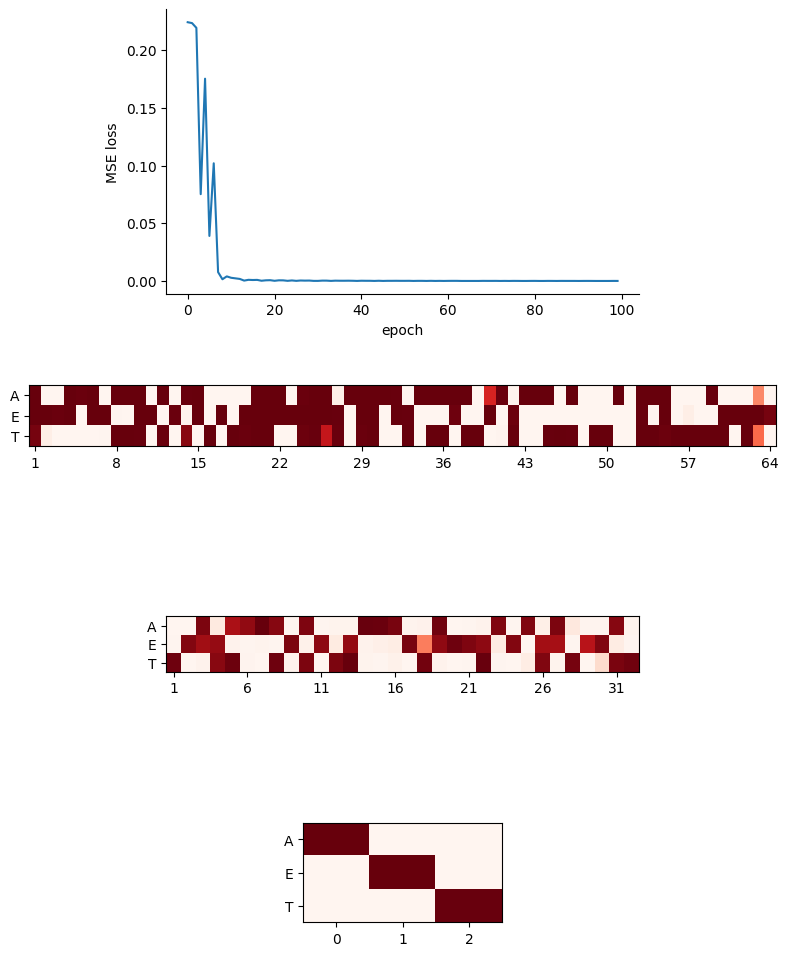

In [ ]:
# plot

from matplotlib.gridspec import GridSpec


font = {'weight' : 'normal',
        'size'   : 10,
        'family' : 'sans-serif'}
plt.rc('font',**font)


plt.rcParams["figure.figsize"] = (8,10)


fig = plt.figure()

gs = GridSpec(4, 6, figure=fig,height_ratios= [1, 0.75, 0.75, 0.75])
ax1 = fig.add_subplot(gs[0, 1:5])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1,:])
ax3 = fig.add_subplot(gs[2, 1:5])
ax4 = fig.add_subplot(gs[3, 2:4])

ax1.spines[['right', 'top']].set_visible(False)
ax1.set_xlabel('epoch')
ax1.set_ylabel('MSE loss')
ax1.plot(np.arange(num_epo_),loss_hist2.detach().cpu())

ax2.imshow(H21[idx].detach().cpu().numpy(),cmap='Reds',interpolation='nearest',aspect=1.75)
ax2.set_xticks(np.arange(0,64,7))
ax2.set_xticklabels(np.arange(1,65,7))
ax2.set_yticks(np.arange(3))
ax2.set_yticklabels(['A', 'E','T'])


ax3.imshow(H22[idx].detach().cpu().numpy(),cmap='Reds',interpolation='nearest', aspect=1.25)
ax3.set_xticks(np.arange(0,32,5))
ax3.set_xticklabels(np.arange(1,32,5))
ax3.set_yticks(np.arange(3))
ax3.set_yticklabels(['A', 'E','T'])

ax4.imshow(O2[idx].detach().cpu().numpy(),cmap='Reds',interpolation='nearest',aspect=.5 )
ax4.set_xticks(np.arange(3))
ax4.set_xticklabels(np.arange(3))
ax4.set_yticks(np.arange(3))
ax4.set_yticklabels(['A', 'E','T'])

fig.tight_layout()
plt.show()

# Explore dynamics single neuron

Dynamics in each hidden unit

$\tau_H \frac{dH_j}{dt} = -H_j + \sigma (\frac{Z_j - R_j + \alpha (t) + H_j}{S})$


Relaxation dynamics

$\tau_R = \frac{dR_j}{dt} = -R_j + c \cdot H_j$

### Explore best settings for *c*


According to linear stability analysis, the frequency of the oscillations is defined as

$$
f_0 = \frac{1}{2\pi}
\sqrt{ 4 c \; \frac{\tau_H}{\tau_R} \; \frac{a}{S} \; H^* (1 - H^* ) - \left( \frac{a}{S} \; H^* (1 - H^* ) + \frac{\tau_H}{\tau_R} - 1 \right)^2 }
$$

with $H^* = \frac{Z}{c-1} $.

$f = \frac{f_0}{\tau_H}$ is the frequency in Hz

We are now trying to explore optimum parameters for $c$

In [ ]:
tau_h = 0.01
tau_R = 0.05
S = .1
a = 2


# explore the maximum value for Z (dot product)
Z = torch.max(Z21).detach().cpu().item()


# explore c's
c_vec = np.arange(Z,3*Z,.5)

f = np.zeros_like(c_vec)
for i,c in enumerate(c_vec):

  Hx = Z/(c-1)
  f[i] = 1/2*np.pi * np.sqrt(4*c*(tau_h/tau_R)*(a/S)*Hx*(1-Hx) - ((a/S)*Hx*(1-Hx)+(tau_h/tau_R)-1)**2)

<ipython-input-38-4baf1a0bead4>:18: RuntimeWarning: invalid value encountered in sqrt
  f[i] = 1/2*np.pi * np.sqrt(4*c*(tau_h/tau_R)*(a/S)*Hx*(1-Hx) - ((a/S)*Hx*(1-Hx)+(tau_h/tau_R)-1)**2)


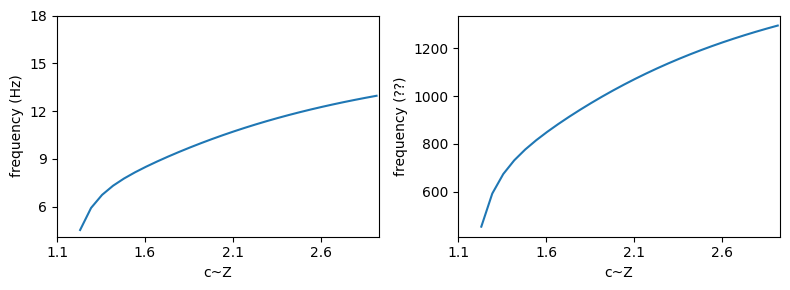

In [ ]:
plt.rcParams["figure.figsize"] = (8,3)

fig = plt.figure()
gs = GridSpec(1, 2,figure=fig)
ax1 = fig.add_subplot(gs[0])
# identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
ax2 = fig.add_subplot(gs[1])


# f0
ax1.plot(c_vec,f)
ax1.set_xticks(np.arange(np.round(Z),4*np.round(Z),4))
ax1.set_xlim((np.round(Z),3*Z))
ax1.set_xticklabels(np.round(np.arange(np.round(Z),4*np.round(Z),4)/Z,decimals=1))
ax1.set_xlabel('c~Z')
ax1.set_ylabel('frequency (Hz)')
ax1.set_yticks(np.arange(6,20,3))

# f ???
ax2.plot(c_vec,f/tau_h)
ax2.set_xticks(np.arange(np.round(Z),4*np.round(Z),4))
ax2.set_xlim((np.round(Z),3*Z))
ax2.set_xticklabels(np.round(np.arange(np.round(Z),4*np.round(Z),4)/Z,decimals=1))
ax2.set_xlabel('c~Z')
ax2.set_ylabel('frequency (??)')
#ax2.set_yticks(np.arange(6,20,3))

fig.tight_layout()
plt.show()

$c = 1.5 *Z$ to $c = 2*Z $ seems to work well

In [ ]:
def euler_dyn_2layer(model,input_,params_,t_,alpha_params,DEVICE,inp_on):

    # inputs:
        # input_: input image
        # params_: hyperparameters
        # t_: time vector for integration
        # alpha_params: alpha frequency & amplitude

    # discretization & dynamics parameters
    tau_h,tau_R,c,S,h_start,R_start = params_


    # alpha frequency & amplitude
    _af,_aa,_aph = alpha_params


    with torch.no_grad():

        # preactivation (dot product of input and first weight matrix)
        Z,_,_,_= model.forw_conv(input_)

        # initialize empty matrices
        dt = np.diff(t_)[0]
        dh1dt = (torch.ones((model.dims[1],len(t_)+1))*h_start).to(DEVICE)
        dR1dt = (torch.zeros((model.dims[1],len(t_)+1))).to(DEVICE)
        dR1dt[:,0] = ((c*torch.max(Z))/(c*torch.max(Z)-1))*Z
        dh1dt[:,0] = Z/(c*torch.max(Z)-1)

        dh2dt = (torch.ones((model.dims[2],len(t_)+1))*h_start).to(DEVICE)
        dR2dt = (torch.ones((model.dims[2],len(t_)+1))*R_start).to(DEVICE)

        dOdt = (torch.zeros((model.dims[3],len(t_)+1))).to(DEVICE)
        dZdt = (torch.zeros((model.dims[1],len(t_)+1))).to(DEVICE)
        dZ2dt = (torch.ones((model.dims[2],len(t_)+1))*h_start).to(DEVICE)

        # alpha inhibition
        alpha_inh1 = _aa[0]*np.sin(2*np.pi*_af[0]*t_+_aph[0])+_aa[0]
        alpha_inh2 = _aa[1]*np.sin(2*np.pi*_af[1]*t_+_aph[0])+_aa[1]




        # create boxcar function to try different input onsets
        boxcar = np.zeros_like(t_)
        boxcar[inp_on:] = 1

        for _it,t in enumerate(t_):

            # dynamic input: multiply input with boxcar
            Z,H1,H2,O = model.forw_conv(input_*boxcar[_it])

          # pre-activation
            dZdt[:,_it+1] = (Z + dh1dt[:,_it] - dR1dt[:,_it] - alpha_inh1[_it])/S

            # dynamics hidden layer
            dh1dt[:,_it+1] = dh1dt[:,_it] + dt/tau_h * (-dh1dt[:,_it] + model.acti1(dZdt[:,_it+1],model.sig_param[0]))

            # adaptation term
            dR1dt[:,_it+1] = dR1dt[:,_it] + dt/tau_R * (-dR1dt[:,_it] + (c*torch.max(Z))*dh1dt[:,_it+1])


            # pre-activation layer 2
            Z2 =  model.fc1(H1)

            dZ2dt[:,_it+1] = (model.fc1(dh1dt[:,_it+1]) + dh2dt[:,_it+1] - dR2dt[:,_it]- alpha_inh2[_it])/S
            # dynamics hidden layer1
            dh2dt[:,_it+1] = dh2dt[:,_it] + dt/tau_h * (-dh2dt[:,_it] + aet_net_2lay.sigmoid(dZ2dt[:,_it+1],model.sig_param[1]))

            # # adaptation term 2
            dR2dt[:,_it+1] = dR2dt[:,_it] + dt/tau_R * (-dR2dt[:,_it] + (c*torch.max(Z2))*dh2dt[:,_it+1])

            # output layer
            dOdt[:,_it+1] = model.actiout(model.fc2(dh2dt[:,_it+1]))

    return dZdt, dZ2dt, dh1dt, dR1dt, dh2dt, dR2dt,dOdt

start dynamics at fixed point
$R = \frac{c}{c-1}Z$ and
$H = \frac{Z}{c-1}$

In [ ]:
# Dynamics one input

tau_h = 0.01
tau_R = 0.1
S = .1
c = 1.5

h_start = 0
R_start = 1

t_start = 0     # when stimulus presented
t = 0             # when to begin plot

params = [tau_h,tau_R,c,S,h_start,R_start]

# alpha parameters
afreq = [10,10]
aamp = [0,0]
aph = [0,0]

alpha_params = [afreq,aamp,aph]

timevec = np.linspace(0,1,1000)


Z1t,Z2t,H1t,R1t, H2t, R2t, Ot = euler_dyn_2layer(model2,x_train[0],params,timevec,alpha_params,DEVICE,t_start)


In [ ]:
Z21,H1,H2,O = model2.forw_conv(x_train[0])
H1 = H1.detach().cpu().numpy()
H2 = H2.detach().cpu().numpy()
O = O.detach().cpu().numpy()

In [ ]:
# the simulations and code are not perfectly aligned??

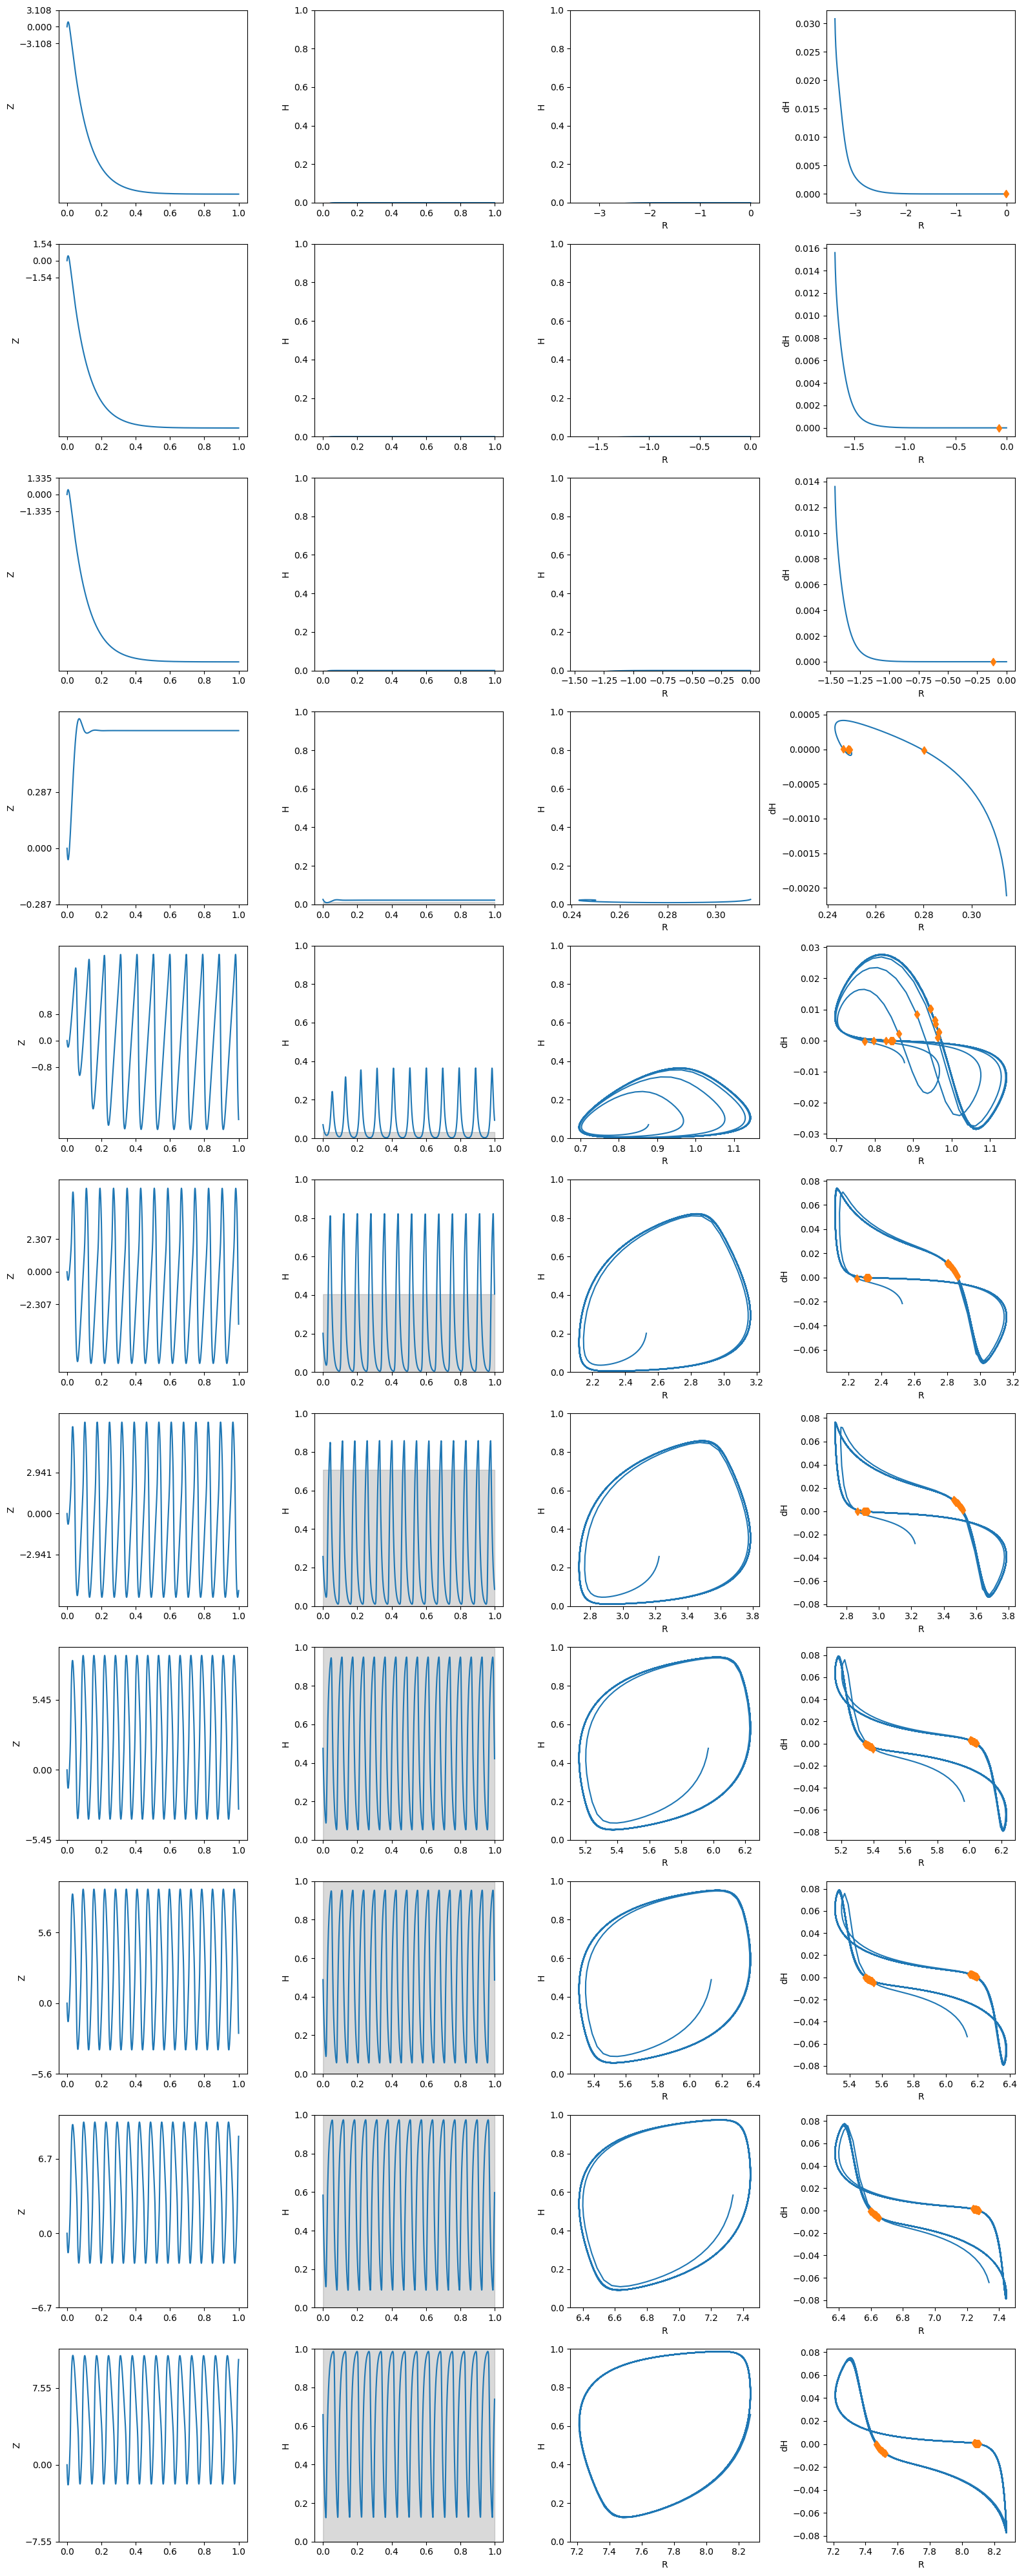

In [ ]:
# Use this c to explore dynamics in hidden node

Z = Z21.detach().cpu()
Z_round = np.round(Z)
Z_round_idx = np.argsort(Z_round)
Z_round_sort = np.sort(Z_round)
Z_round_unique_idx = np.unique(Z_round_sort,return_index=True)

plt.rcParams["figure.figsize"] = (16,40)

fig, axs = plt.subplots(Z_round_unique_idx[1].shape[0],4)

t = 0

for i,z in enumerate(Z_round_unique_idx[1]):
  axs[i,0].plot(timevec[t:],Z1t[Z_round_idx[z],t+1:])
  axs[i,0].set_yticks((-Z[Z_round_idx[z]],0,Z[Z_round_idx[z]]))
  axs[i,0].set_ylabel('Z')
  axs[i,1].plot(timevec[t:],H1t[Z_round_idx[z],t+1:])

#if aamp:
   # axs[i,1].plot(timevec[t:],0.5*np.sin(2*np.pi*afreq*timevec[t:]+aph)+0.5,color = 'k',linestyle='-.')
  axs[i,1].fill_between(timevec[t:], np.tile(0,timevec[t:].shape[0]), np.tile(H1[Z_round_idx[z]],timevec[t:].shape[0]), alpha=0.15, color=[0, 0, 0])
  axs[i,1].set_ylabel('H')

  axs[i,1].set_ylim(0,1)
  axs[i,2].plot(R1t[Z_round_idx[z],t+1:],H1t[Z_round_idx[z],t+1:])
  axs[i,2].set_ylim(0,1)
  axs[i,2].set_xlabel('R')
  axs[i,2].set_ylabel('H')

  dH = np.diff(H1t[Z_round_idx[z]])

  mark_sign_chan = np.array(())
  for h in range(dH.shape[0]-1):
    if (np.sign(dH[h])+np.sign(dH[h+1])) == 0:
      mark_sign_chan = np.append(mark_sign_chan,h)

  axs[i,3].plot(R1t[Z_round_idx[z],t+1:],dH)
  axs[i,3].plot(R1t[Z_round_idx[z],(t+1+mark_sign_chan).astype(int)],dH[(t+mark_sign_chan).astype(int)],'d')
  axs[i,3].set_xlabel('R')
  axs[i,3].set_ylabel('dH')


fig.tight_layout()